**Содержание темы**
1. [Теория](https://colab.research.google.com/drive/1mgQaPN1eqhzNpTYTqbbXZHmolI7d2yll?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1dApswu6lfXEWfPl9ZgTspfFIneWGQIOq?usp=sharing)

3. Практика 2

Привет!

Это второй из двух практических ноутбуков по теме **Автокодировщики**.

Здесь вы:
* закрепите знания, полученные в предыдущей практике;
* построите и обучите модель автокодировщика на изображениях с лицами людей;
* напишете алгоритм генерации шума на этих изображениях;
* узнаете, как на практике модель удаляет шум с изображений;
* построите и обучите модель для распознавания мошеннических транзакций.

#Автокодировщики: примеры решения прикладных задач


В этом разделе вы напишете и обучите модель автокодировщика, удаляющего шум с изображений.

##Импорт библиотек

In [ ]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# Готовые датасеты
from tensorflow.keras.datasets import mnist, fashion_mnist

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

## Удаление шума на изображениях лиц

В данном разделе решается задача удаления шума с изображений.

### Архитектура автокодировщика

Рассмотрите функцию создания модели НС. В данном случае вы практически все знаете.
Есть только одна особенность: вместо **MaxPooling** применен параметр **strides** слоя
**Conv2D**, который отвечает за то, насколько уменьшится изображение. Наши эксперименты показали, что такая замена в данной задаче дает лучший результат (хотя, возможно, вы сможете создать архитектуру лучше нашей, но с MaxPooling).

In [ ]:
# Функция сборки свёрточного автокодировщика
def create_base_ae(in_shape):

  inputs = Input(in_shape)

  # 3 блока свертки перед сжатием
  x = Conv2D(12, 3, padding='same', activation='relu')(inputs)
  x = BatchNormalization()(x)

  # используем разрежение (dilation_rate) для выявления мелких деталей изображения
  x = Conv2D(24, 3, dilation_rate=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 1
  x = Conv2D(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(96, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # Сжатие 2
  x = Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(256, 3, padding='same', activation='relu')(x)

  # Скрытое пространство
  z = BatchNormalization()(x)

  x = Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(z)
  x = BatchNormalization()(x)

  x = Conv2D(128, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2DTranspose(96, 3, strides=2, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(48, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(24, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(8, 3, padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  # финальный слой свертки, выход модели
  outputs = Conv2D(1, 2, dilation_rate=2, padding='same', activation='sigmoid')(x)

  # Сборка модели. На входе оригинальное изображение, на выходе - сжатое-восстановленное
  model = Model(inputs, outputs)

  # компиляция модели
  model.compile(optimizer=Adam(1e-4),
                loss='mse')

  return model

Скорость экспериментально выбрана равной $10^{-4}$ (в Python пишется как `1e-4`) как оптимальный выбор между качеством результата и времени обучения. При более высокой скорости модель в некоторый момент момент начинает "скакать" около более оптимальных весов, но не стремиться к ним. А при более низкой скорости модель обучается слишком медленно.

###Сервисные функции

In [ ]:
# Функция последовательного вывода нескольких изображений для сравнения
def plot_images(target_images, noised_images, pred, shape=None, n=4):
    if shape is None:                               # Автоопределение формы данных
        shape = target_images.shape[1:3]                   # форма изображения

    plt.figure(figsize=(n*4, n*4), dpi=100)                     # Размер полотна
    plt.subplots_adjust(hspace=0.2, wspace=0.001)

    for i in range(0, n):                              # Повтор n раз:
        index = np.random.randint(0, pred.shape[0]) # Выбор случайного индекса

        # Показ картинки с индексом index из оригинального набора
        ax = plt.subplot(n, 4, 4*i + 1)               # Картинка располагается в верхнем ряду
        plt.imshow(target_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Оригинал')

        # Показ шумовой картинки с тем же индексом
        ax = plt.subplot(n, 4, 4*i + 2)           # Картинка располагается в среднем ряду
        plt.imshow(noised_images[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Зашумлённое изображение')

        # Показ картинки с тем же индексом из предсказания автокодировщика
        ax = plt.subplot(n, 4, 4*i + 3)           # Картинка располагается в нижнем ряду
        plt.imshow(pred[index].reshape(shape), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Предсказание')

        # Показ разницы предсказания и зашумленной картинки
        ax = plt.subplot(n, 4, 4*i + 4)           # Картинка располагается в нижнем ряду
        plt.imshow(noised_images[index].reshape(shape) - pred[index].reshape(shape),
                   cmap='gray', vmin=0, vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title('Извлечённый шум')

    plt.show()

###Определение оптимального порога

In [ ]:
# Функция поиска оптимального порога
# На входе - mse на верном наборе и наборе выбросов,
# количество шагов порога и указание, показывать график или нет
def find_optimal_threshold(err_true, err_wrong, points=1000, factor = 2., show=True):
    # Сетка порогов между средней и кратной максимальной ошибками с малым шагом
    thresholds = np.linspace(err_true.mean(), factor * err_true.max(), points)

    # Массив значений ошибок для каждого значения порога
    errors_true = np.empty(thresholds.shape)
    errors_wrong = np.empty(thresholds.shape)
    errors_overall = np.empty(thresholds.shape)

    # Расчет ошибок на верных и неверных данных, общей ошибки
    # для каждого порога, и занесение ошибок в массивы
    for i in range(thresholds.shape[0]):
        errors_true[i] = 1 - (err_true < thresholds[i]).mean()
        errors_wrong[i] = (err_wrong < thresholds[i]).mean()
        errors_overall[i] = errors_true[i] + errors_wrong[i]

    # Определение индекса оптимального порога по минимальной общей ошибке
    optimal_i = np.argmin(errors_overall)

    # Если требуется, вывод картинки и статистик
    if show:
        plt.figure(figsize=(14,7))
        plt.plot(thresholds, errors_true, label='На верных данных')
        plt.plot(thresholds, errors_wrong, label='На выбросах')
        plt.plot(thresholds, errors_overall, label='Общая ошибка')
        plt.plot(thresholds[optimal_i], errors_overall[optimal_i], 'ro')
        plt.xlabel('Порог')
        plt.ylabel('Ошибки')
        plt.legend()
        plt.title('График ошибок при разных порогах')
        plt.show()

        print('Оптимальный порог: {:.4f}'.format(thresholds[optimal_i]))
        print('Распознано как норма на верных данных: {:.2f}%'.format(100 * (1 - errors_true[optimal_i])))
        print('Распознано как норма на выбросах     : {:.2f}%'.format(100 * errors_wrong[optimal_i]))
        print('Суммарная ошибка: {:.2f}%'.format(100 * errors_overall[optimal_i]))

    # Возврат оптимальных значений: индекс, значение порога и все ошибки
    return optimal_i, \
           thresholds[optimal_i], \
           errors_true[optimal_i], \
           errors_wrong[optimal_i], \
           errors_overall[optimal_i]

###Загрузка датасета и подготовка данных

В первую очередь загрузите датасет по ссылке:

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l13/facez.zip', None, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l13/facez.zip
To: /content/facez.zip
100%|██████████| 444M/444M [00:19<00:00, 22.4MB/s]


'facez.zip'

Разархивируйте его командой `!unzip` в папку **faces**:

In [ ]:
# Распаковка архива в папку faces
!unzip -qo facez.zip -d faces/

Рассмотрите константы, которые в дальнейшем вам потребуются.

In [ ]:
# Настройка констант
IMG_DIR = 'faces'                         # Папка с изображениями
IMG_HEIGHT = 112                          # Высота изображений
IMG_WIDTH = 80                            # Ширина избражений
VAL_SPLIT = 0.05                          # Доля проверочной выборки от основного набора

Чтобы получить
полноценный датасет, загрузите изображения и объедините их в один список. Для этого
напишите функцию, в которой вы создадите пустой список для изображений. Затем
пройдитесь в цикле по всем изображениям в папке и добавьте их в список. Подробнее:

* `os.path.join(folder, img)` – объединяете путь к файлу из двух частей,
пути к папке и название файла;
* `target_size=(height, width)` – новая размерность изображений;
* `color_mode='grayscale'` – к какой цветовой гамме привести изображения, в
данном случае – к черно-белому формату;
* `image.load_img()` – подгружаете изображения;
* `image.img_to_array()` – превращаете рисунок в массив данных.

На выходе функции будет массив с изображениями.

In [ ]:
# функция загрузки изображений
# На входе: имя папки с изображениями, высота и ширина, к которым будут приведены изображения
def load_images(folder, height, width):
    image_list = []                       # Список для изображений
    for img in os.listdir(folder):        # Перебор по именам файлов в папке
        # Добавление в список изображения в виде массива,
        # в заданных размерах и в оттенках серого
        image_list.append(image.img_to_array(image.load_img(os.path.join(folder, img),
                                                             target_size=(height, width),
                                                             color_mode='grayscale')))
    # Возврат массива-результата
    return np.array(image_list)

Засечём время и посмотрим за сколько все наши изображения подгрузятся. Выведем результат на экран.

In [ ]:
# Загрузка датасета в память
cur_time = time.time()
data_faces = load_images(IMG_DIR, IMG_HEIGHT, IMG_WIDTH)
print(f'Время загрузки: {round(time.time()-cur_time)} с.')

Время загрузки: 16 с.


Не забудьте нормализовать данные и привести их в диапазон от 0 до 1.

In [ ]:
# Сжатие диапазона [0, 255] значений к диапазону [0, 1]
data_faces = data_faces.astype('float32') / 255.

Разделите датасет на тренировочные и тестовые целевые изображение функцией `train_test_split`.

In [ ]:
# Разбиение на обучающие и проверочные целевые изображения
y_train, y_test = train_test_split(data_faces, test_size=VAL_SPLIT)

> Данная задача нестандартна тем, что весь исходный датасет – это целевые изображения. А исходных данных пока нет, потому что исходные данные – это те же целевые изображенния, но с шумом, который пока не сгенерирован.

In [ ]:
# Размерность выборки
print(y_train.shape, y_test.shape, sep='\n')

(4767, 112, 80, 1)
(251, 112, 80, 1)


Выборка получается небольшой. Но для демонстрации этого достаточно.

Выведите случайное изображение на экран.<br>
Для этого можно сначала выбрать случайный индекс, по которому потом мы получим изображение.

In [ ]:
# Выбор индекса случайного изображения из тренировочных
random_index = np.random.randint(0, y_train.shape[0])

Для визуализации можно использовать `plt`. <br>
При одноканальных изображениях этот фреймворк требует убирать уже лишнюю ось каналов, так как она всего одна, поэтому избыточна. Это можно сделать функцией `.squeeze()`.

In [ ]:
# Удаление последней оси для корректной работы plt
random_img = y_train[random_index].squeeze(axis=-1)

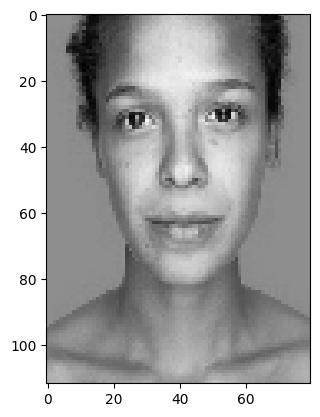

In [ ]:
# Вывод примера в черно-белом формате
plt.imshow(random_img, cmap='gray')
plt.show()

### Шум

Теперь сгенерируйте шумовые картинки.

Для этого можно использовать функцию `np.random.standard_normal`. Функция генерирует случайные значения согласно стандартному нормальному распределению.

Случайные значения стандартного распределения нам не очень подходят – слишком большой разброс и слишком много отрицательных чисел. Поэтому сжимаем шум в 30 раз и сдвигаем на 0.5.

In [ ]:
# генерируем тензор случайных значения сразу равных по количеству и форме наших данных
train_noise = np.random.standard_normal(y_train.shape)/30 + .5
test_noise = np.random.standard_normal(y_test.shape)/30 + .5

Теперь на каждый пиксель каждого тренировочного и тестового изображения есть случайное (шумовое) значение. Чтобы лучше понять, что это за числа, построим гистограмму.

Число случайных значений на гистограмме: (42712320,)


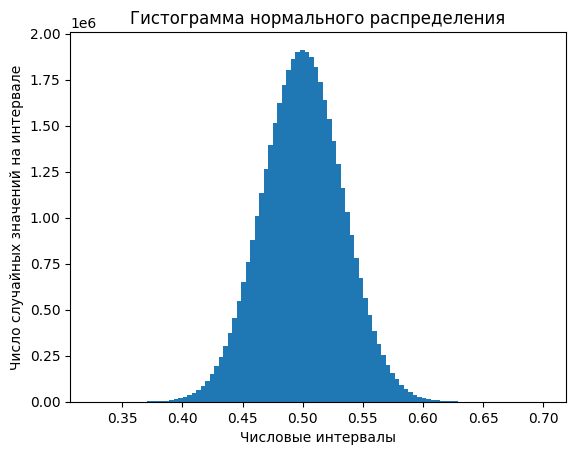

In [ ]:
print("Число случайных значений на гистограмме:", train_noise.reshape(-1).shape)

plt.figure(dpi=100)
_ = plt.hist(train_noise.reshape(-1), bins=100)
plt.ylabel('Число случайных значений на интервале')
plt.xlabel('Числовые интервалы')
plt.title("Гистограмма нормального распределения")
plt.show()

Ось случайно сгенерированных чисел делится на 100 интервалов (число интервалов может быть любым). Далее каждому интервалу ставится в соответствие столб (вертикальная ось). Высота этого столба – это количество случайных чисел, попавших в этот интервал.

In [ ]:
# создадим зашумленные изображения
X_train = y_train + train_noise
X_test = y_test + test_noise

Отобразите случайное оригинальное изображение, прибавляемый к нему шум и зашумленное изображение.

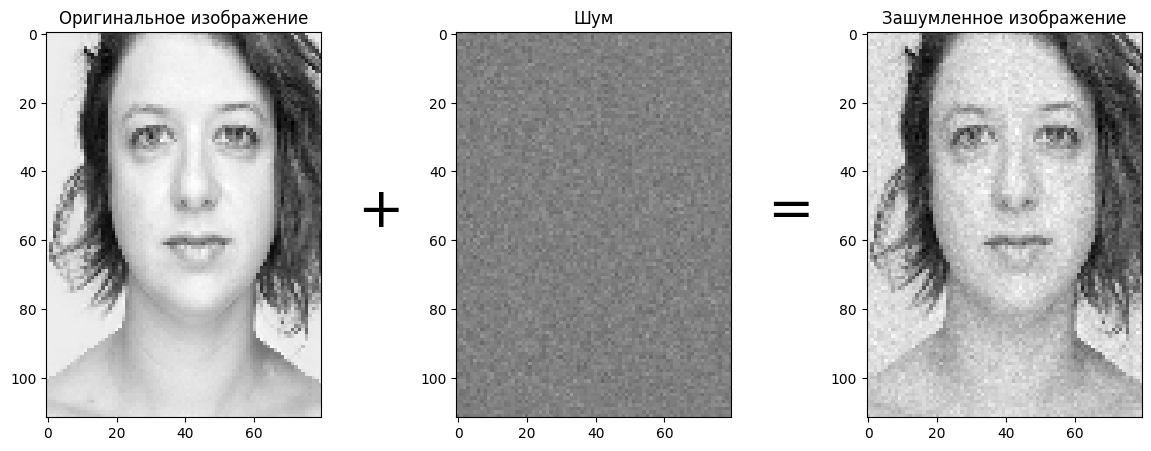

In [ ]:
# Создаем полотно
fig = plt.figure(figsize=(15, 5))

# Выбираем индекс изображения случайно
choice = np.random.randint(0, X_train.shape[0])

# Создаем области ax для отрисовки изображений
ax_1 = fig.add_subplot(1, 3, 1)
ax_2 = fig.add_subplot(1, 3, 2)
ax_3 = fig.add_subplot(1, 3, 3)

# Отрисовываем изображения
ax_1.imshow(y_train[choice].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
ax_2.imshow(train_noise[choice].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray', vmin=0, vmax=1)
ax_3.imshow(X_train[choice].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')

# Подписываем
ax_1.set_title('Оригинальное изображение')
ax_2.set_title('Шум')
ax_3.set_title('Зашумленное изображение')

ax_1.text(IMG_WIDTH+10, IMG_HEIGHT/2, '+', fontsize=40)
ax_2.text(IMG_WIDTH+10, IMG_HEIGHT/2, '=', fontsize=40)

# прописываем пустую инструкцию, иначе выведется значение, возвращенное ax_2 (которое нам не нужно)
pass

Таким образом мы получили к каждой оригинальной картинке зашумленный аналог. Теперь создадим автокодировщик, пытающийся отчистить этот шум, вернув картинку к исходному состоянию.

###Создание и обучение автокодировщика

Создайте и обучите НС. Процесс ничем не отличается от того, что вы рассмотрели в первой практике.


In [ ]:
# Создание автокодировщика
ae_faces = create_base_ae(X_train.shape[1:])

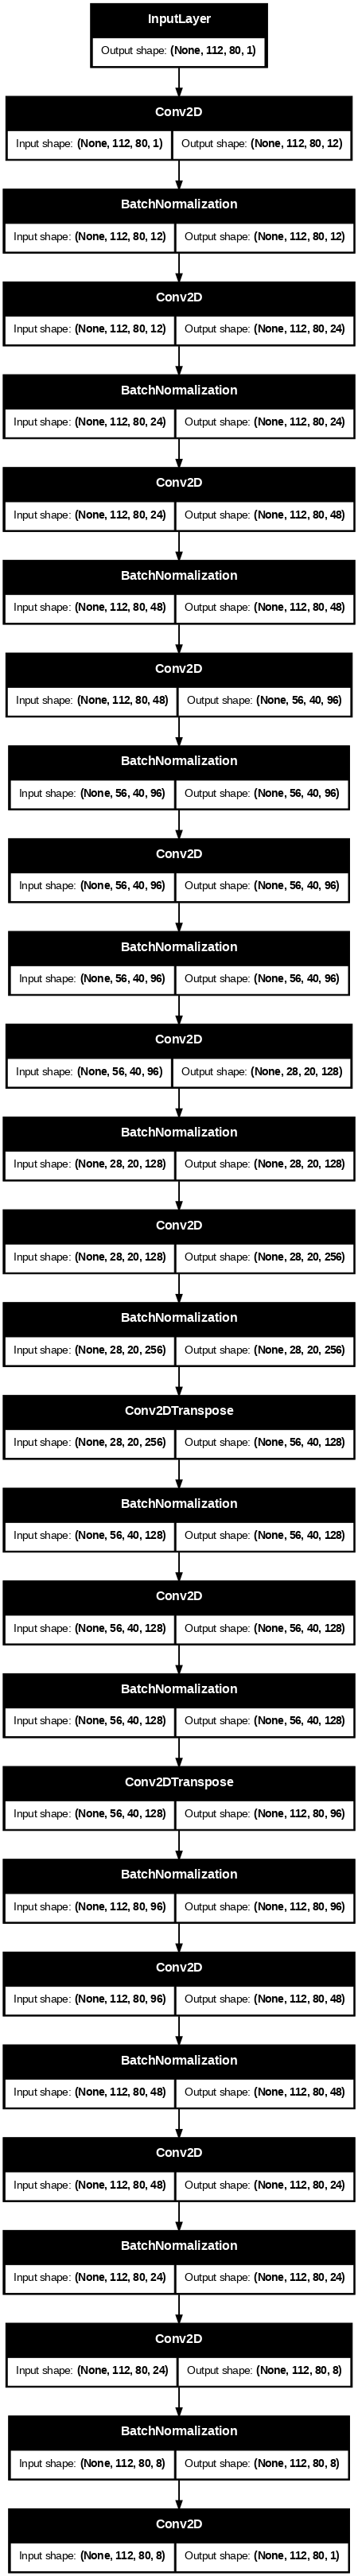

In [ ]:
# Отображение модели
utils.plot_model(ae_faces, show_shapes=True, dpi=70)

In [ ]:
# Обучение модели на датасете лиц
ae_faces.fit(X_train, y_train,
             epochs=50,
             batch_size=8,
             validation_data=(X_test, y_test))

Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - loss: 0.0188 - val_loss: 0.0048
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 4/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 7/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 9/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 10/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 11/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 12/50
596/596 ━━━━━━━━━━

Судя по функции ошибки модель обучилась отлично: <br> MSE loss на тесте < $10^{-3}$ за ~20 мин. <br>  Переобучение не наблюдается.

#### Ошибка на тесте меньше ошибки на тренировке. Как такое может быть?

Такое происходит, когда какой-либо слой в модели ведет себя по-разному при тестировании и при обучении. Это слои типа Dropout и BatchNormalization.

---
Дополнительная информация ([База знаний УИИ - «**Слой BatchNormalization**»](https://colab.research.google.com/drive/1tT74848tqrvZuQ2InRrxTH6U1P9FvD-K))

---



### Сохранение

Создадите папку для модели.

In [ ]:
# Путь к папке для хранения моделей
PATH = '/content/my_ae_models'

# Создадим папку для моделей, если её еще нет
if not os.path.isdir(PATH):
  os.mkdir(PATH)

На первой практике вы сохранили веса модели. Это был первый способ сохранения результата. Второй способ – сохранить саму модель. Делается это через метод `ae_faces.save`. Загрузка через `tf.keras.models.load_model`

In [ ]:
# Сохранение/восстановление всей модели
ae_faces.save(PATH + 'ae_faces.keras') # Сохраняем модель
ae_faces = load_model(PATH + 'ae_faces.keras') # Загружаем модель

###Проверка результатов

Посмотрите, как НС предсказывает изображение. Сделайте предсказание на основе
тренировочных данных и выведите изображения ниже.

In [ ]:
# Получение предсказания автокодировщика на обучающей выборке
pred = ae_faces.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 506ms/step


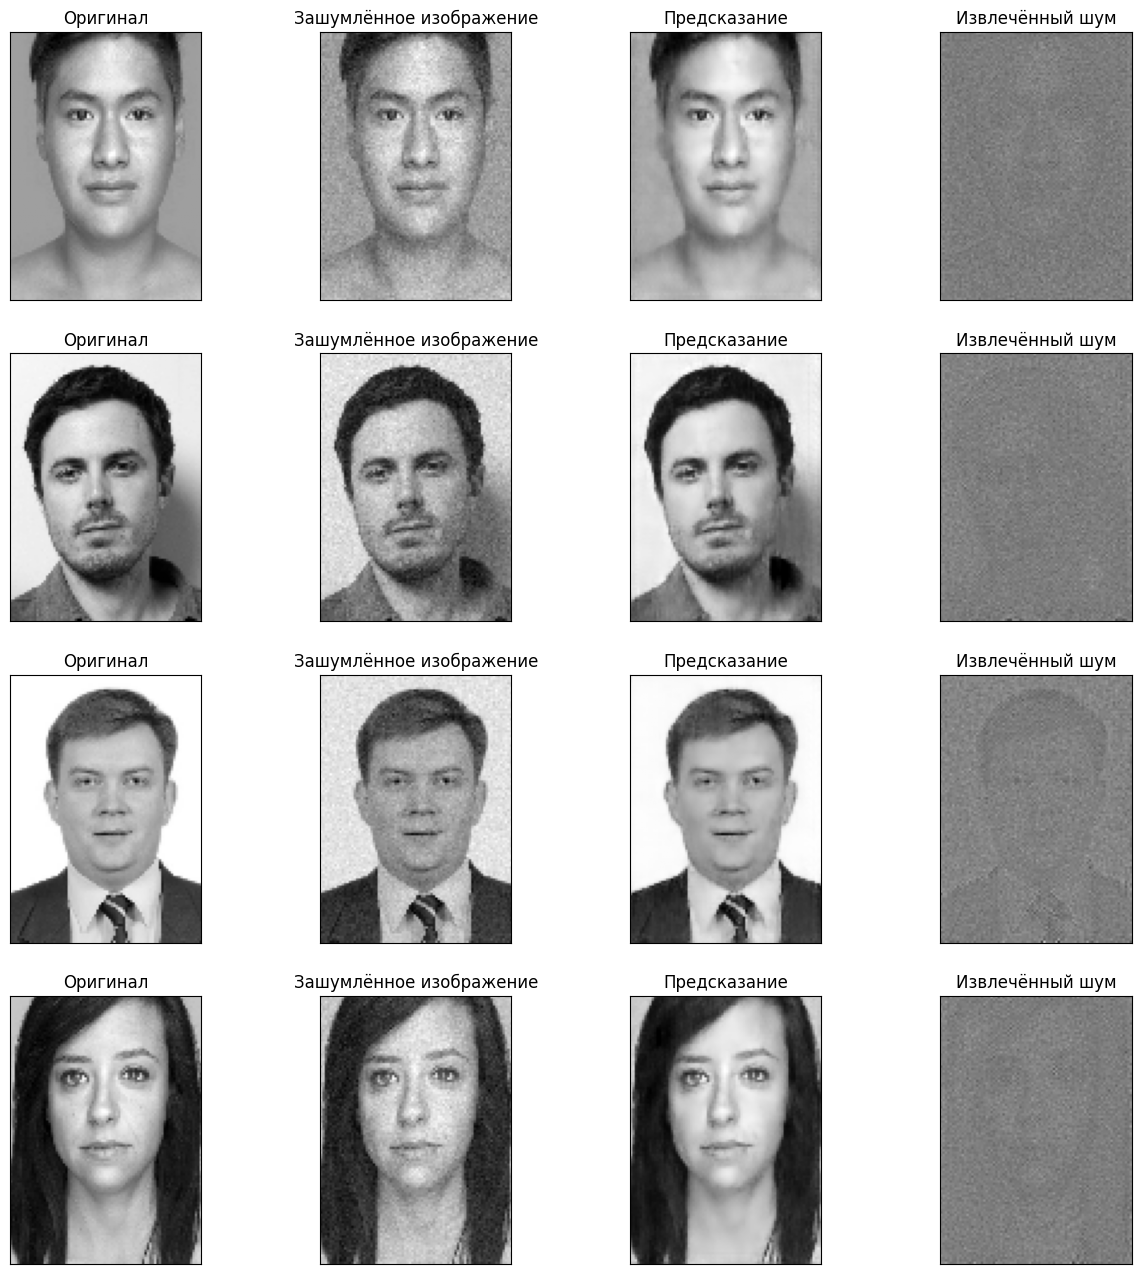

In [ ]:
# Сравнение исходных и восстановленных картинок из обучающей выборки
plot_images(y_test, X_test, pred)

Видно, что изображения на выходе модели на вид очень похожы на оригинальные. Шум в значительной степени убран с изображений, сами лица восстановлены с большей частью деталей. Если приглядеться, можно увидеть небольшое размытие на предсказаниях.
Некоторые детали (например, щетина) нейросеть распознала как шум и попыталась убрать.

Если еще поэкспериментировать с моделью, то, возможно, получится добиться лучших результатов. Можно добавить больше слоев, поэкспериментировать с размерами ядер, разрежением ядер, каналами имеющихся слоев. Иными словами есть еще простор для усложнения модели за счет того, что переобучения нет. Либо, вероятно, наоборот – модель попроще даст лучший результат.

Как видите, удаление шумов с изображения – не такая сложная задача, какой могла показаться. А что насчет мошеннических транзакций?

##Определение мошеннических операций на датасете транзакций по кредитным картам


В данном разделе рассматривается решение задачи обнаружения мошеннических транзакций по кредитным картам.

###Загрузка датасета и подготовка данных

Загрузите датасет по ссылке.

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l13/creditcard.csv', None, quiet=True)

'creditcard.csv'

Переведите его в массив данных и посмотрите содержимое.

In [ ]:
# Чтение данных в таблицу
df = pd.read_csv("creditcard.csv")

In [ ]:
# Вывод первых строк таблицы
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


*Признаки V1, V2, ... – значения функций преобразования [PCA](https://habr.com/ru/post/304214/). Исходные данные не предоставляются источником из соображений конфиденциальности.*

Практически все данные уже готовы к работе с НС. Есть только два замечания: лишний
столбец со временем и то, что нужно нормализовать данные в столбце «сумма».

Удалите столбец *Time*.

In [ ]:
data = df.drop(['Time'], axis=1)

Нормализуйте столбец *Amount*.

In [ ]:
data['Amount'] = (data['Amount'] - data['Amount'].mean())/ data['Amount'].std()

Разделите на два отдельных датафрейма по признаку класса.

In [ ]:
# Выделение данных нормальных и мошеннических операций
fraud_data = data[data.Class == 1]
normal_data = data[data.Class == 0]

Посмотрите размерность получившихся данных. Вышел огромный перевес в сторону
нормальных операций. Соответственно, бинарная классификация не подходит.
Используйте автокодировщик для поиска выбросов.

In [ ]:
# Вывод формы полученных массивов
print(fraud_data.shape)
print(normal_data.shape)

(492, 30)
(284315, 30)


Разделите нормальные данные в соотношении 0.8/0.2 на обучающую и тестовую выборки.

In [ ]:
# Разбивка нормальных данных на обучающую и тестовую выборки
x_train, x_test = train_test_split(normal_data, test_size=0.2)

Завершите подготовку данных:
* уберите столбец *Class* из набора тренировочных данных, так как в них только
нормальные операции;
* объедините тестовые выборки нормальных и мошеннических операций с помощью `pd.concat()`;
* создайте набор данных с ответами для тестовой выборки. Возьмите данные из
столбца *Class* тестовой выборки;
* удалите столбец *Class* из тестовых данных;
* преобразуйте все данные в Numpy-массивы.

In [ ]:
# Удаление столбца класса из обучающей выборки
x_train = x_train.drop(['Class'], axis=1)
# Добавление всех мошеннических транзакций в тестовую выборку
x_test = pd.concat([x_test, fraud_data])
# Создание меток класса для тестовой выборки
y_test = x_test['Class']
# Удаление столбца класса из тестовой выборки
x_test = x_test.drop(['Class'], axis=1)
# Преобразование данных в массивы numpy
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

Проверьте, что все данные сходятся по размерности.

In [ ]:
# Проверка формы полученных выборок
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(227452, 29)
(57355, 29)
(57355,)


###Создание и обучение автокодировщика

Создайте простую и быструю в обучении НС из пары полносвязных слоев. Число признаков – 29. Размер латентного пространства должен быть меньше. Пусть это будет, например, 10.

In [ ]:
# Функция создания автокодировщика для определения мошеннических транзакций
def create_credit_ae(in_parameters, latent_dim=10):
    # Вход
    input = Input(shape=(in_parameters,))

    # Полносвязные внутренний и финальный слои
    x = Dense(latent_dim, activation='relu')(input)
    output = Dense(in_parameters, activation='linear')(x)

    # Сборка и компиляция модели
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=Adam(0.0001), loss='mse')

    return model

In [ ]:
# Создание автокодировщика
ae_credit = create_credit_ae(x_train.shape[1])

Обучите НС.

In [ ]:
# Обучение автокодировщика, на входе и выходе - нормальные транзакции
history = ae_credit.fit(x_train, x_train,
                        epochs=50,
                        batch_size=32)

Epoch 1/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.0769
Epoch 2/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.6066
Epoch 3/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.4788
Epoch 4/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.4052
Epoch 5/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3898
Epoch 6/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3740
Epoch 7/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3682
Epoch 8/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3644
Epoch 9/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3629
Epoch 10/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3563
Epoch 11/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3583
Epoch 12/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3583
Epoch 13/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.3610
Epoch 14/50
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3519
Epoch 15/50
710

Сохраните веса модели на вашем гугл-диске.

In [ ]:
ae_credit.save_weights(PATH + 'ae_credit.weights.h5') # Сохраняем модель
ae_credit.load_weights(PATH + 'ae_credit.weights.h5') # Загружаем модель

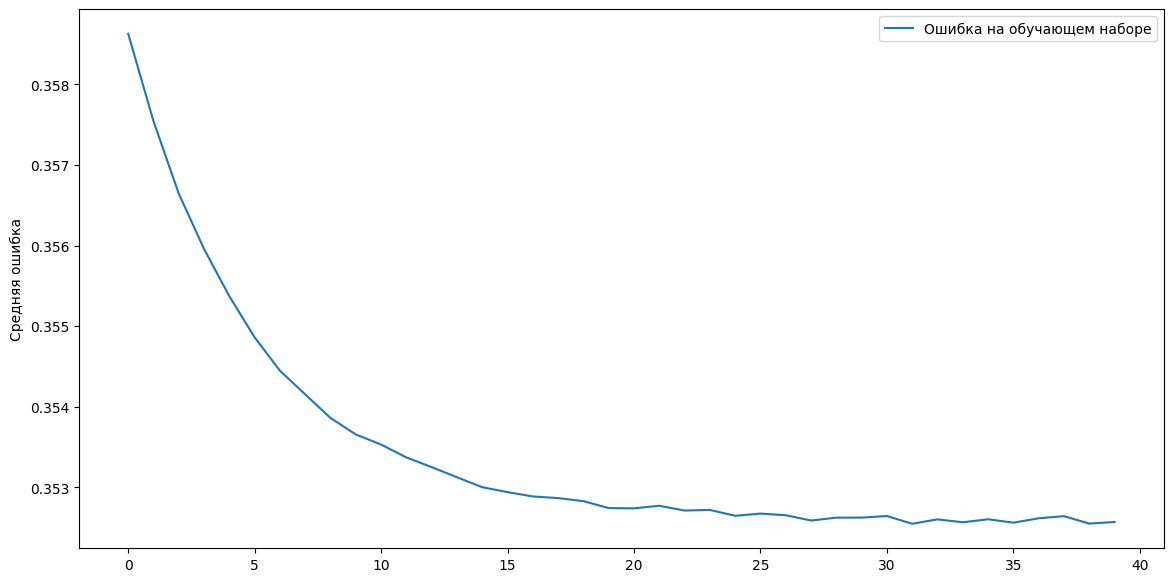

In [ ]:
# Вывод графика процесса обучения
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'][10:],
         label='Ошибка на обучающем наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Как видно по графику, ошибка на обучающей выборке имеет скачкообразный характер, но тренд нисходящий.

###Определение выбросов


Сделайте предсказание вашего автокодировщика на основе тестовой выборки.

Подсчитайте ошибки на каждом наборе данных и выведите график, на котором отметьте оптимальный порог для отделения мошеннических операций (выбросов).

In [ ]:
# Получение предсказания автокодировщика на тестовой выборке (нормальные + мошеннические транзакции)
pred_test = ae_credit.predict(x_test)

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# Вычисление среднеквадратических ошибок на тестовой выборке
err_test = mean_squared_error(x_test.T,
                               pred_test.T,
                               multioutput='raw_values')

# Выделение ошибок на нормальных и мошеннических транзакциях
err_normal = err_test[y_test == 0]
err_fraud = err_test[y_test == 1]

In [ ]:
print('Минимальная  ошибка нормальных транзакций: {:.5f}'.format(err_normal.min()))
print('Максимальная ошибка нормальных транзакций: {:.5f}'.format(err_normal.max()))
print('Средняя      ошибка нормальных транзакций: {:.5f}'.format(err_normal.mean()))

Минимальная  ошибка нормальных транзакций: 0.04168
Максимальная ошибка нормальных транзакций: 69.97714
Средняя      ошибка нормальных транзакций: 0.35429


In [ ]:
print('Минимальная  ошибка мошеннических транзакций: {:.5f}'.format(err_fraud.min()))
print('Максимальная ошибка мошеннических транзакций: {:.5f}'.format(err_fraud.max()))
print('Средняя      ошибка мошеннических транзакций: {:.5f}'.format(err_fraud.mean()))

Минимальная  ошибка мошеннических транзакций: 0.15935
Максимальная ошибка мошеннических транзакций: 145.79848
Средняя      ошибка мошеннических транзакций: 20.31876


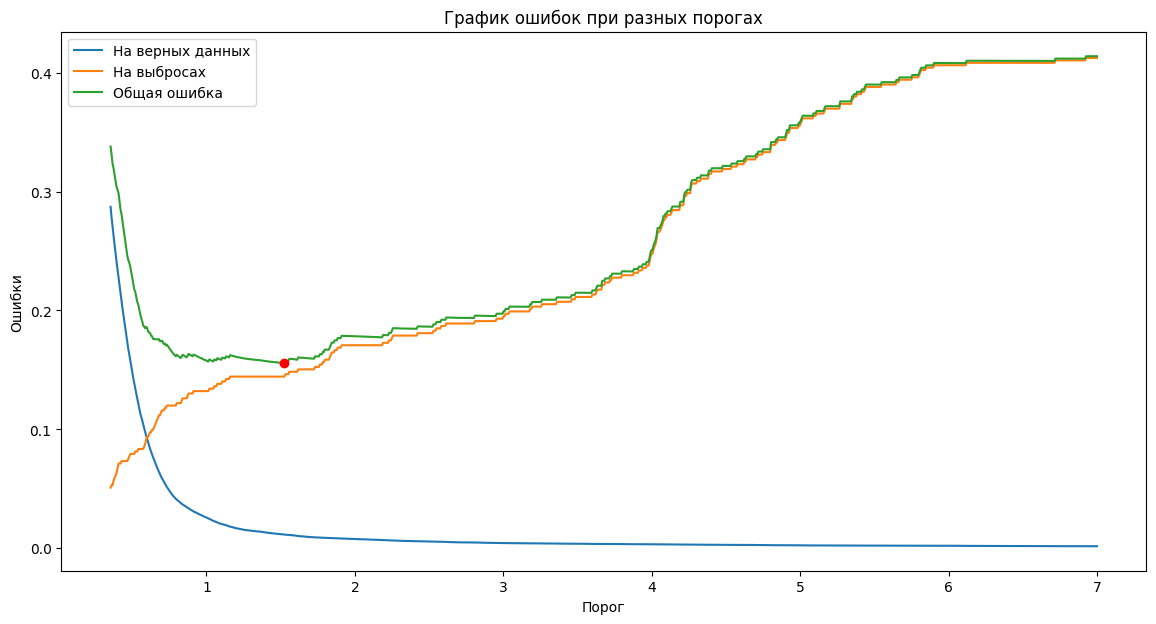

Оптимальный порог: 1.5247
Распознано как норма на верных данных: 98.87%
Распознано как норма на выбросах     : 14.43%
Суммарная ошибка: 15.57%


In [ ]:
# Определение оптимального порога для нормальных и мошеннических транзакций
_, threshold, _, _, _ = find_optimal_threshold(err_normal, err_fraud, factor=0.1)

In [ ]:
# Вычисление доли верно распознанных нормальных и мошеннических транзакций
found_normal = (err_normal < threshold).mean()
found_fraud = (err_fraud >= threshold).mean()

# Вывод статистик
print('Распознано    нормальных транзакций: {:.2f}%'.format(100. * found_normal))
print('Распознано мошеннических транзакций: {:.2f}%'.format(100. * found_fraud))
print('Средняя точность распознавания     : {:.2f}%'.format(50. * (found_normal + found_fraud)))

Распознано    нормальных транзакций: 98.87%
Распознано мошеннических транзакций: 85.57%
Средняя точность распознавания     : 92.22%


Итак, создана и обучена модель автокодировщика с целью отделения мошеннических от нормальных транзакций. В целом задача решена успешно – средняя точность распознавания ~92%. В этой задаче была взята максимально простая модель, что оставляет большое пространство для экспериментов. Поэтому при желании вы можете попробовать усложнить архитектуру для получения лучшего результата.

## Важно: о точности распознавания выбросов

В реальных задачах точность распознавания выбросов, например мошеннических
транзакций, может по важности превалировать над точностью распознавания нормальных
данных. В таком случае при определении оптимального порога и статистик используйте
взвешенное, а не простое среднее этих двух параметров точности. Веса зададут меру
важности параметров точности относительно друг друга. Значения весов подбирайте
исходя из конкретного случая.

## Итог

Итак, вы прошли вторую практику по теме **Автокодировщики**.
<br> На этой практике вы:
* закрепили знания, полученные в предыдущей практике и в теории;
* научились чистить изображения от шума;
* научились определять мошеннические транзакции в условиях сильного дисбаланса классов;

На этом завершается тема **Автокодировщики**. Поздравляем с прохождением!

Теперь вы полностью готовы к решению домашнего задания. Но прежде, чем выполнять ДЗ сложности **Lite и выше**, советуем опробовать свои силы на примерах из задачника.

---
[УИИ **Задачник** к теме «Архитектура автокодировщика»](https://colab.research.google.com/drive/1u6GP8ZpcP_nSYrJ_b0YfnVXlDtaaoVaT)

---


**Содержание темы**

1. [Теория](https://colab.research.google.com/drive/1mgQaPN1eqhzNpTYTqbbXZHmolI7d2yll?usp=sharing)

2. [Практика 1](https://colab.research.google.com/drive/1dApswu6lfXEWfPl9ZgTspfFIneWGQIOq?usp=sharing)

3. Практика 2